# Indroduction
Text Classification Algorithm are at the heart of a variety of software systems that process text data at scale. Email software uses Text Classification to determine whether incomin email is sent to the inbox or filtered into the spam folder. Discussion forum use text classification to determine whether comments should be flagged as inappropiate.

These are two example of text classification, categorizing a text document into one of the predefined set of topics. In many topic classification problem, this categorization is based primarily on keywords in the texts.

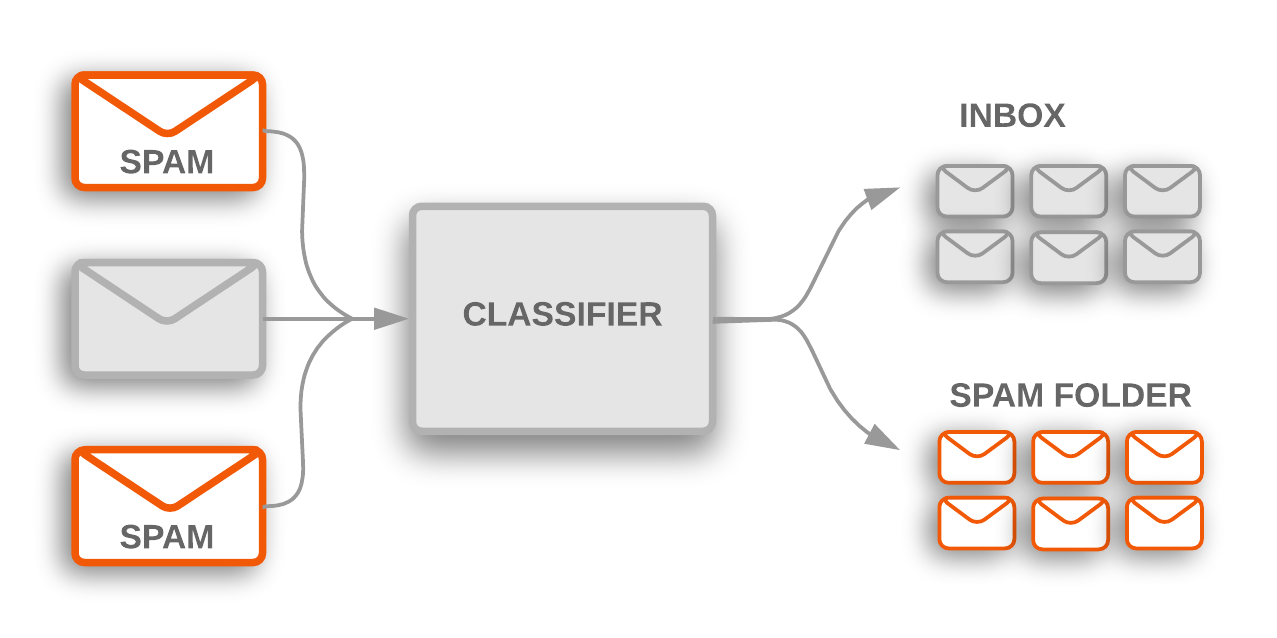

### Figure 1. Topic classification is used to flag incoming spam emails, which the filter into the spam folder.
Another type of text classification is sentiment analysis, whose goal is to identify the polarity of text content: the type of opinion it expresses. This can take the form of binary like/dislike rating, or a more granual set of options, such as star rating from 1 to 5. Example of sentiment analysis include analyzing twitter posts to determine if people liked the black panthor movie, or extrapolating the general public opinion of a new brand of nike shoes from walmart reviews.

This guide will teach you smoke key machine learning best practices for solving text classification problems.
1. The high level, end-to-end workflow for solving text classification problems using machine learning.
2. How to choose the right model for your text classification problem.
3. How to implement model of choice using TendorFlow.

## Text Classification Work Flow
 Here is a high level overview:
 * Step 1   - Gather Data
 * Step 2   - Explore your Data
 * Step 2.5 - Choose a Model
 * Step 3   - Prepare your Data
 * Step 4   - Bild, train and evaluate your model
 * Step 5   - Tune Hyperparameters
 * Step 6   - Deploy your Model
 
 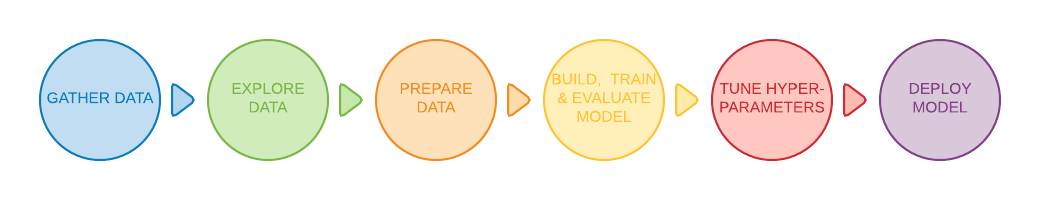
 
### Figure 2. Workflow for solving machine learning problems
 
# Step 1: Gather Data
Gathering data is the most important step in solving any supervised machine learning problem. Your text classifier can only be as good as the dataset it is built from.
If you don’t have a specific problem you want to solve and are just interested in exploring text classification in general, there are plenty of open source datasets available. You can find links to some of them in our GitHub repo. On the other hand, if you are tackling a specific problem, you will need to collect the necessary data. Many organizations provide public APIs for accessing their data—for example, the Twitter API or the NY Times API. You may be able to leverage these for the problem you are trying to solve.
Here are some important things to remember when collecting data:
If you are using a public API, understand the limitations of the API before using them. For example, some APIs set a limit on the rate at which you can make queries.
The more training examples (referred to as samples in the rest of this guide) you have, the better. This will help your model generalize better.
Make sure the number of samples for every class or topic is not overly imbalanced. That is, you should have comparable number of samples in each class.
Make sure that your samples adequately cover the space of possible inputs, not only the common cases.
Throughout this guide, we will use the Internet Movie Database (IMDb) movie reviews dataset to illustrate the workflow. This dataset contains movie reviews posted by people on the IMDb website, as well as the corresponding labels (“positive” or “negative”) indicating whether the reviewer liked the movie or not. This is a classic example of a sentiment analysis problem.

# Step 2: Explore your Data
Building and training a model is only one part of the workflow. Understanding the characteristics of your data beforehand will enable you to build a better model. This could simply mean obtaining a higher accuracy. It could also mean requiring less data for training, or fewer computational resources


# Uploading Data

In [ ]:
from pathlib import Path
import os
import random
import numpy as np
def load_imdb_sentiment_analysis_dataset(data_path, seed=123):
    imdb_data_path = os.path.join(data_path, 'aclImdb')
    train_texts = []
    train_labels = []
    for category in ['pos', 'neg']:
        train_path = os.path.join(imdb_data_path, 'train', category)
        for fname in sorted(os.listdir(train_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(train_path, fname),encoding='utf-8') as f:
                    train_texts.append(f.read())
                train_labels.append(0 if category == 'neg' else 1)    
    test_texts = []
    test_labels = []
    for category in ['pos', 'neg']:
        test_path = os.path.join(imdb_data_path, 'test', category)
        for fname in sorted(os.listdir(test_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(test_path, fname), encoding='utf-8') as f:
                    test_texts.append(f.read())
                test_labels.append(0 if category == 'neg' else 1)    
    random.seed(seed)
    random.shuffle(train_texts)
    random.seed(seed)
    random.shuffle(train_labels)
    
    return((train_texts, np.array(train_labels)),
           (test_texts, np.array(test_labels)))
a,b = load_imdb_sentiment_analysis_dataset('')



In [ ]:
print(a[0][12])
print(a[1][12])

### Check the Data
After loading the data, it’s good practice to run some checks on it: pick a few samples and manually check if they are consistent with your expectations. For example, print a few random samples to see if the sentiment label corresponds to the sentiment of the review. Here is a review we picked at random from the IMDb dataset: “Ten minutes worth of story stretched out into the better part of two hours. When nothing of any significance had happened at the halfway point I should have left.” The expected sentiment (negative) matches the sample’s label.

Collect Key Metrics

Once you’ve verified the data, collect the following important metrics that can help characterize your text classification problem:

Number of samples: Total number of examples you have in the data.
Number of classes: Total number of topics or categories in the data.
Number of samples per class: Number of samples per class (topic/category). In a balanced dataset, all classes will have a 
                             similar number of samples; in an imbalanced dataset, the number of samples in each class will vary                              widely.
Number of words per sample: Median number of words in one sample.
Frequency distribution of words: Distribution showing the frequency (number of occurrences) of each word in the dataset.
Distribution of sample length: Distribution showing the number of words per sample in the dataset.

   

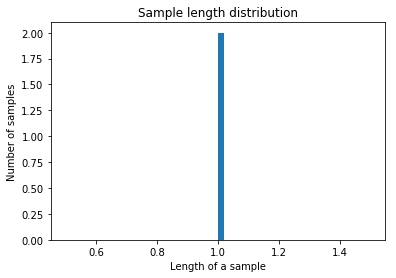

In [6]:
from __future__ import absolute_import
from __future__ import division
from __future__  import print_function

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

def get_num_classes(labels):
    """ Get the number of classes
    Arguments:
    labels- list, label values.
             Thre should be atleast one sample of values in the
             range(0, num_classes-1)
    
    Returns:
      int, total number od classes.
    Raises
        ValueError: if any label value in the range(0, num_classes - 1)
            is missing or if number of classes is <= 1.
    """  
    
    num_classes = max(labels+1)
    missing_classes = [i for i in range(num_classes) if i not in labels]
    if len(missing_classes):
        raise ValueError('missing smaples with label value(s)'
                         '{missing_classes}. Please make sure you have'
                         ' in the range(0, {max_class})'.format(
                          missing_classes = missing_classes, max_class = num_classes-1))
    
    if num_classes <= 1:
        raise ValueErroe('Invalid number of labels: {num_classes}.'
                         ' Please make sure their are aleast two classes'
                         'of samples'.format(num_classes=num_classes))
    return num_classes

def get_num_words_per_sample(sample_texts):
    """Gets the median number of words per sample given corpus.
    # Arguments
        sample_texts: list, sample texts.
    # Returns
        int, median number of words per sample.
    """
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)

def plot_frequency_distribution_of_ngrams(sample_texts,
                                          ngram_range=(1, 2),
                                          num_ngrams=50):
                                          
 
    # Create args required for vectorizing.
    
    kwargs = {'ngram_range':(1, 1),
              'dtype':'int32',
              'strip_accents':'unicode',
              'decode_error':'replace',
              'analyzer':'word'}
    vectorizer = CountVectorizer(**kwargs)
    
    # This creates a vocabulary (dict, where keys are n-grams and values are
    # idxices). This also converts every text to an array the length of
    # vocabulary, where every element idxicates the count of the n-gram
    # corresponding at that idxex in vocabulary.
    
    vectorized_texts = vectorizer.fit_transform(sample_texts)
    
    # This is the list of all n-grams in the index order fromthe vocabulary.
    all_ngrams = list(vectorizer.get_feature_names())
    num_ngrams = min(num_ngrams, len(all_ngrams))
    

    # ngrams = all_ngrams[:num_ngrams]

    # Add up the counts per n-gram ie. column-wise
    
    all_counts = vectorized_texts.sum(axis=0).tolist()[0]
    # Sort n-grams and counts by frequency and get top `num_ngrams` ngrams.
    all_counts, all_ngrams = zip(*[(c, n) for c, n in sorted(
                             zip(all_counts, all_ngrams), reverse=True)])
    ngrams = list(all_ngrams)[:num_ngrams]
    counts = list(all_counts)[:num_ngrams]
    
    
    idx = np.arange(num_ngrams)
    plt.bat(idx, counts, width=0.8, color='b')
    plt.xlabel("N-grams")
    plt.ylabel("Frequencies")
    plt.title("Frequencies distribution of n-grams")
    plt.xticks(idx, ngrams, rotation=45)
    plt.show()

def plot_sample_length_distribution(sample_texts):
   
               
    plt.hist([len(s) for s in sample_texts], 50)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()


def plot_class_distribution(labels):
    """Plots the class distribution.
    # Arguments
        labels: list, label values.
            There should be at lease one sample for values in the
            range (0, num_classes -1)
    """
    num_classes = get_num_classes(labels)
    count_map = Counter(labels)
    counts = [count_map[i] for i in range(num_classes)]
    idx = np.arange(num_classes)
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('Class')
    plt.ylabel('Number of samples')
    plt.title('Class distribution')
    plt.xticks(idx, idx)
    plt.show()   
               
get_num_words_per_sample('10')
plot_sample_length_distribution('25')


    

# Step 2.5 Choose a Model

At this point, we have assembled our dataset and gained insights into the key characteristics of our data. Next, based on the metrics we gathered in Step 2, we should think about which classification model we should use. This means/ asking questions such as, “How do we present the text data to an algorithm that expects numeric input?” (this is called data preprocessing and vectorization), “What type of model should we use?”, “What configuration parameters should we use for our model?”, etc.

Thanks to decades of research, we have access to a large array of data preprocessing and model configuration options. However, the availability of a very large array of viable options to choose from greatly increases the complexity and the scope of the particular problem at hand. Given that the best options might not be obvious, a naive solution would be to try every possible option exhaustively, pruning some choices through intuition. However, that would be tremendously expensive.

In this guide, we attempt to significantly simplify the process of selecting a text classification model. For a given dataset, our goal is to find the algorithm that achieves close to maximum accuracy while minimizing computation time required for training. We ran a large number (~450K) of experiments across problems of different types (especially sentiment analysis and topic classification problems), using 12 datasets, alternating for each dataset between different data preprocessing techniques and different model architectures. This helped us identify dataset parameters that influence optimal choices.

The model selection algorithm and flowchart below are a summary of our experimentation. Don’t worry if you don’t understand all the terms used in them yet; the following sections of this guide will explain them in depth.

In the flowchart below, the yellow boxes indicate data and model preparation processes. Grey boxes and green boxes indicate choices we considered for each process. Green boxes indicate our recommended choice for each process.

You can use this flowchart as a starting point to construct your first experiment, as it will give you good accuracy at low computation costs. You can then continue to improve on your initial model over the subsequent iterations.

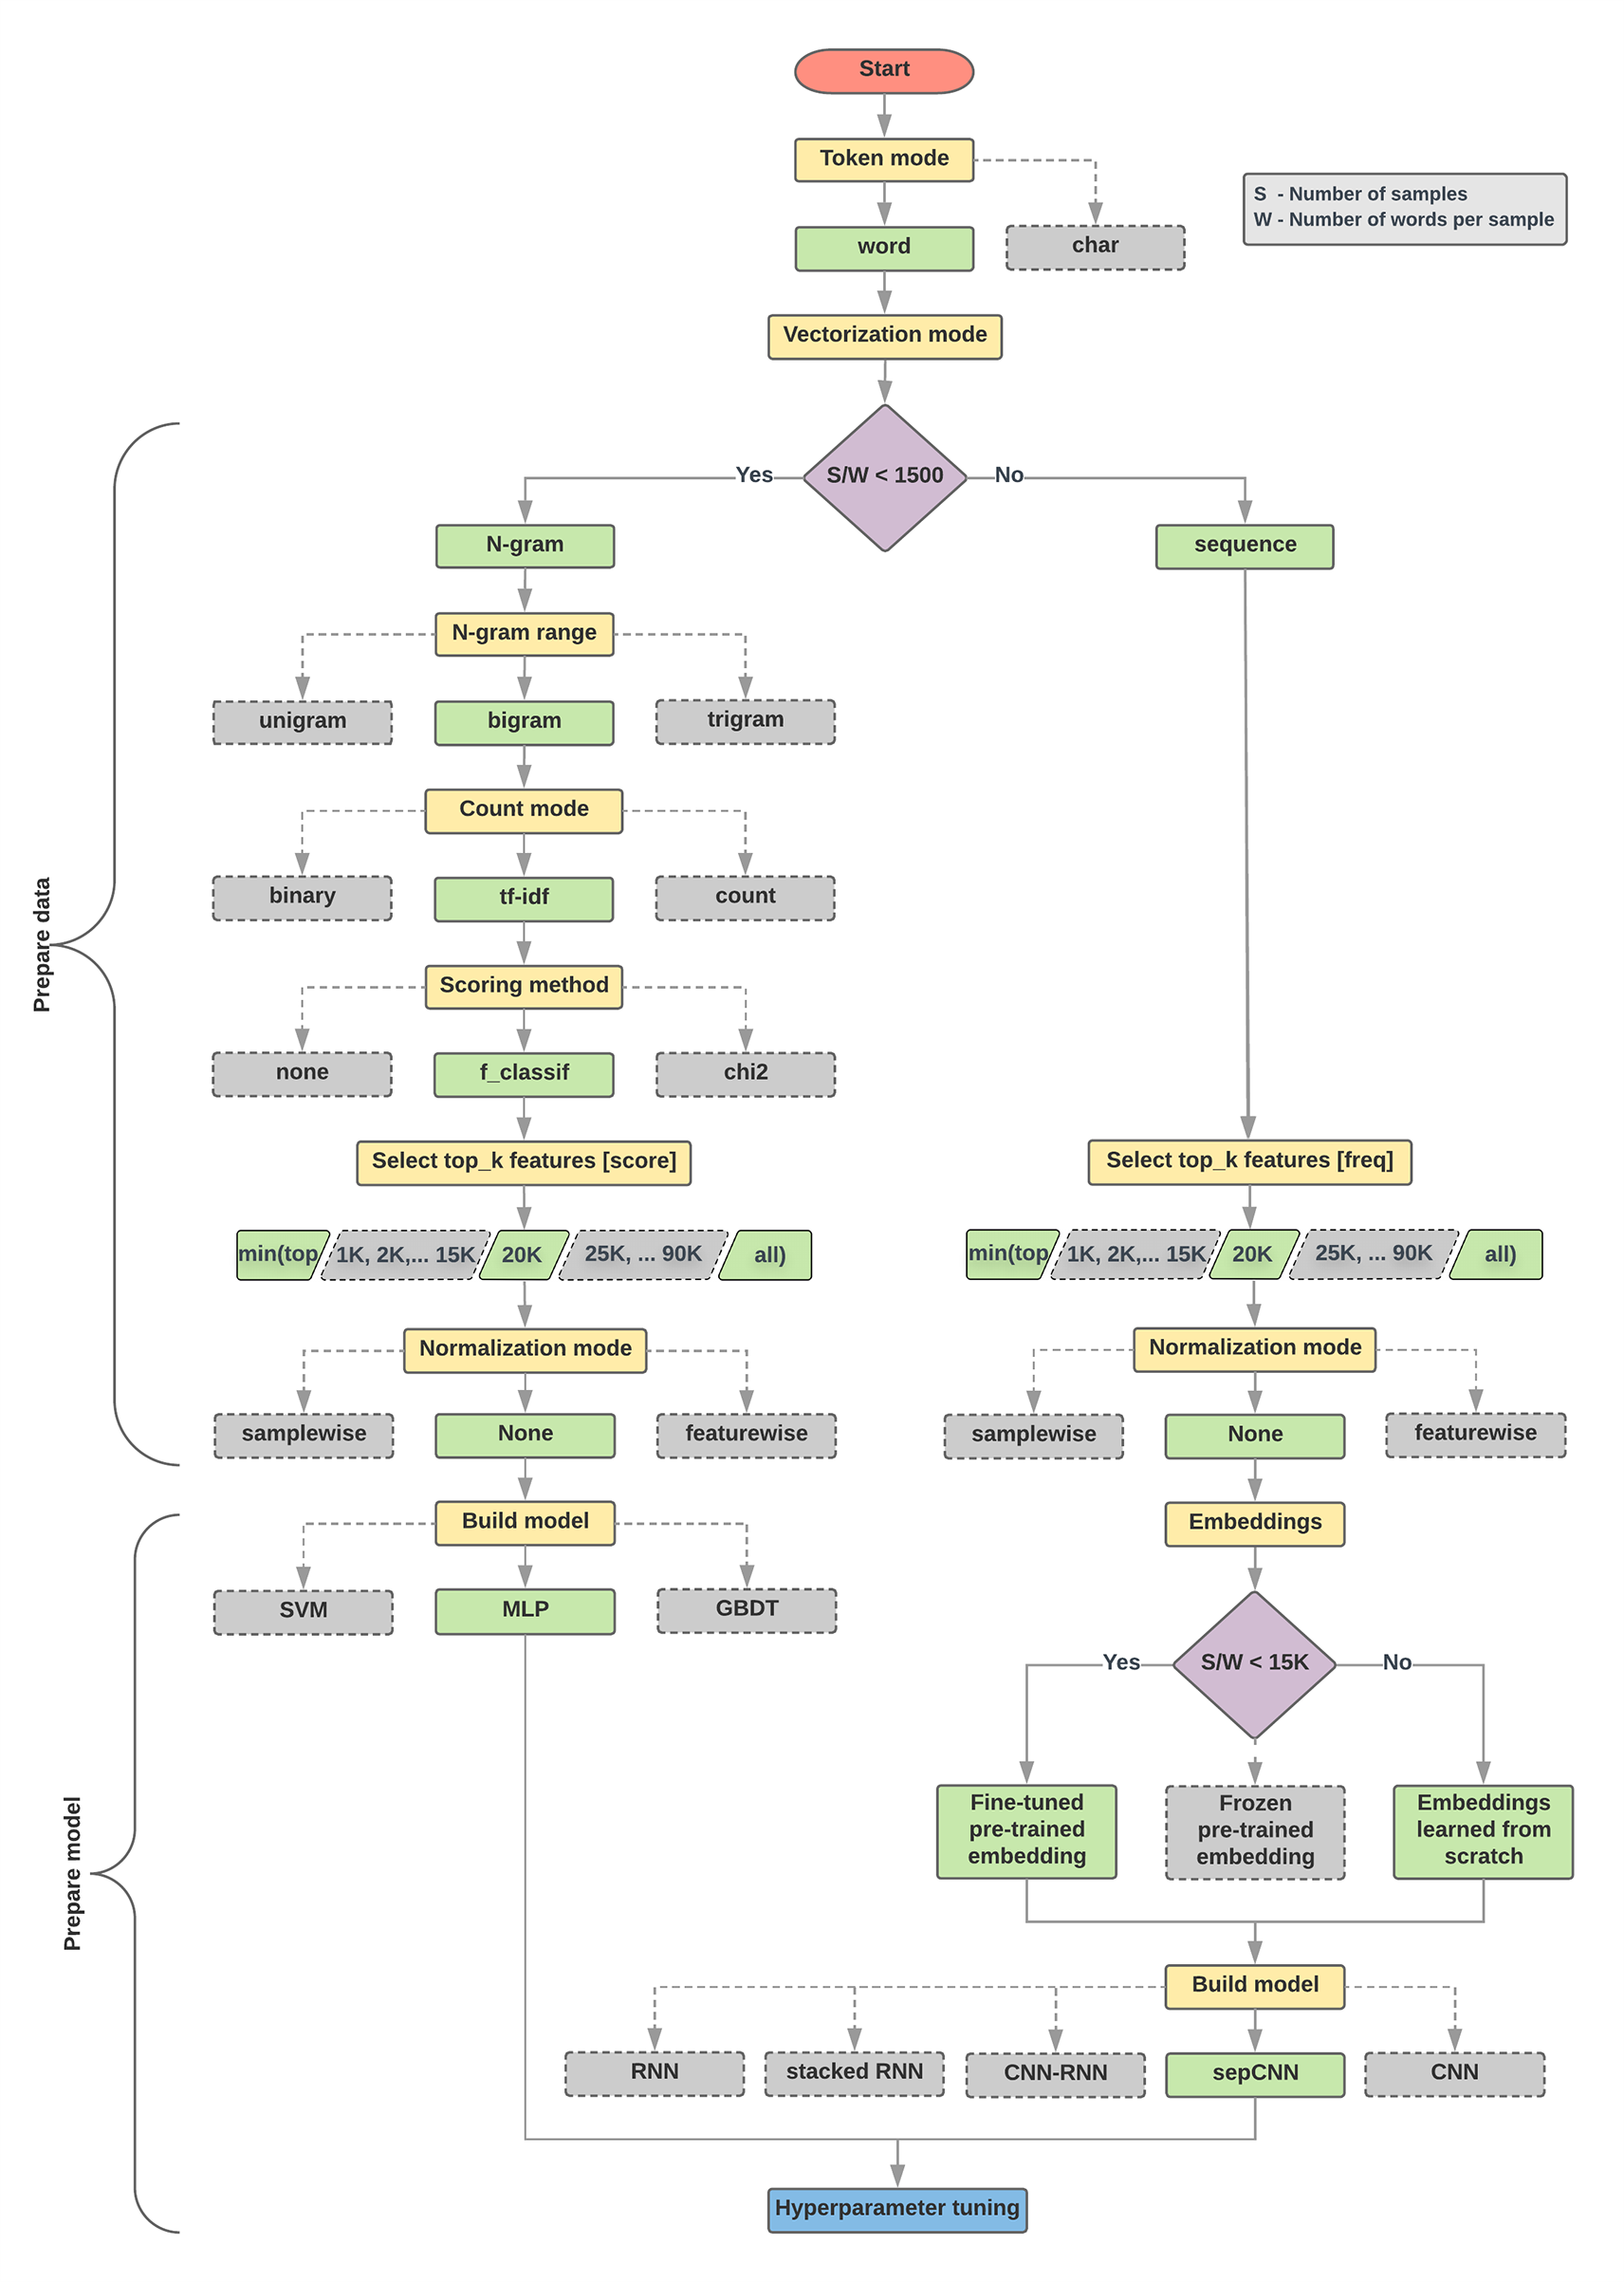

# Step 3: Prepare Your Data 

Before our data can be fed to a model, it needs to be transformed to a format the model can understand.

First, the data samples that we have gathered may be in a specific order. We do not want any information associated with the ordering of samples to influence the relationship between texts and labels. For example, if a dataset is sorted by class and is then split into training/validation sets, these sets will not be representative of the overall distribution of data.

A simple best practice to ensure the model is not affected by data order is to always shuffle the data before doing anything else. If your data is already split into training and validation sets, make sure to transform your validation data the same way you transform your training data. If you don’t already have separate training and validation sets, you can split the samples after shuffling; it’s typical to use 80% of the samples for training and 20% for validation.

Second, machine learning algorithms take numbers as inputs. This means that we will need to convert the texts into numerical vectors. There are two steps to this process:

Tokenization: Divide the texts into words or smaller sub-texts, which will enable good generalization of relationship between the texts and the labels. This determines the “vocabulary” of the dataset (set of unique tokens present in the data).

Vectorization: Define a good numerical measure to characterize these texts.

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

#Vectorization paramater
#range(inclusive) of n gram sizes for tokensizing text
NGRAM_RANGE = (1,2)

#Limit on the number of feature. we use the top 20 k features.
TOP_K = 20000

#Whether text should be split into wards or character n-grams
# one of 'words', 'char'
TOKEN_MODE = 'word'
#minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

def ngram_vectorize(train_texts, train_labels, val_texts):
    """
    Vectorises text as ngram vector
    1 text = 1 tf-idf vector the length of vocabulory of unigrams + bigrams
    #ARGUMENTS:
    train_texts- list, training text string
    train_labels- np.ndarray, training labels
    val_texts- lists, validation text string
    
    #RETURNS:
      x_train, x_val : vectorization training and validation text
    """
    
    #Create keyword argument to pass to the 'tf-idf' vectorizer
    
    kwargs = {
        'ngram_range': NGRAM_RANGE,
        'dtype': 'int32',
        'strip_accents': 'unicode',
        'decode_error': 'replace',
        'analyzer': TOKEN_MODE,
        'min_df': MIN_DOCUMENT_FREQUENCY,
        
    }
    
    vectorizer = TfidfVectorizer(**kwargs)
    
     
    #Learn vocabulary from training texts and vectorize training texts
    
    x_train = vectorizer.fit_transform(train_texts)
    
    #Vectorize Validation texts
    
    x_val = vectorizer.transform(val_texts)
    
    #Select top 'k' of the vectorized feature.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transfrorm(x_val).astype('float32')
    return(x_train, x_val)
    
ngram_vectorize('The mouse ran up the clock', 'the mouseran up clock', 'the mouse mouse ran ran up up the the clock')   
    
    
    
    

UnboundLocalError: local variable 'input' referenced before assignment

### N-gram vectors [Option A]
In the subsequent paragraphs, we will see how to do tokenization and vectorization for n-gram models. We will also cover how we can optimize the n- gram representation using feature selection and normalization techniques.

In an n-gram vector, text is represented as a collection of unique n-grams: groups of n adjacent tokens (typically, words). Consider the text The mouse ran up the clock. Here, the word unigrams (n = 1) are ['the', 'mouse', 'ran', 'up', 'clock'], the word bigrams (n = 2) are ['the mouse', 'mouse ran', 'ran up', 'up the', 'the clock'], and so on.

Tokenization
We have found that tokenizing into word unigrams + bigrams provides good accuracy while taking less compute time.

Vectorization
Once we have split our text samples into n-grams, we need to turn these n-grams into numerical vectors that our machine learning models can process. The example below shows the indexes assigned to the unigrams and bigrams generated for two texts.

 Index assigned for every token: {'the': 7, 'mouse': 2, 'ran': 4, 'up': 10,
  'clock': 0, 'the mouse': 9, 'mouse ran': 3, 'ran up': 6, 'up the': 11, 'the
clock': 8, 'down': 1, 'ran down': 5}
Once indexes are assigned to the n-grams, we typically vectorize using one of the following options.

One-hot encoding: Every sample text is represented as a vector indicating the presence or absence of a token in the text.

'The mouse ran up the clock' = [1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
Count encoding: Every sample text is represented as a vector indicating the count of a token in the text. Note that the element corresponding to the unigram 'the' (bolded below) now is represented as 2 because the word “the” appears twice in the text.

'The mouse ran up the clock' = [1, 0, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1]
Tf-idf encoding: The problem with the above two approaches is that common words that occur in similar frequencies in all documents (i.e., words that are not particularly unique to the text samples in the dataset) are not penalized. For example, words like “a” will occur very frequently in all texts. So a higher token count for “the” than for other more meaningful words is not very useful.

'The mouse ran up the clock' = [0.33, 0, 0.23, 0.23, 0.23, 0, 0.33, 0.47, 0.33,
0.23, 0.33, 0.33] (See Scikit-learn TdidfTransformer)
There are many other vector representations, but the above three are the most commonly used.

We observed that tf-idf encoding is marginally better than the other two in terms of accuracy (on average: 0.25-15% higher), and recommend using this method for vectorizing n-grams. However, keep in mind that it occupies more memory (as it uses floating-point representation) and takes more time to compute, especially for large datasets (can take twice as long in some cases).

Feature selection
When we convert all of the texts in a dataset into word uni+bigram tokens, we may end up with tens of thousands of tokens. Not all of these tokens/features contribute to label prediction. So we can drop certain tokens, for instance those that occur extremely rarely across the dataset. We can also measure feature importance (how much each token contributes to label predictions), and only include the most informative tokens.

There are many statistical functions that take features and the corresponding labels and output the feature importance score. Two commonly used functions are f_classif and chi2. Our experiments show that both of these functions perform equally well.

More importantly, we saw that accuracy peaks at around 20,000 features for many datasets. Adding more features over this threshold contributes very little and sometimes even leads to overfitting and degrades performance.




## Normalization
Normalization converts all feature/sample values to small and similar values. This simplifies gradient descent convergence in learning algorithms. From what we have seen, normalization during data preprocessing does not seem to add much value in text classification problems; we recommend skipping this step.

The following code puts together all of the above steps:

Tokenize text samples into word uni+bigrams,
Vectorize using tf-idf encoding,
Select only the top 20,000 features from the vector of tokens by discarding tokens that appear fewer than 2 times and using f_classif to calculate feature importance.

In [ ]:
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text

# Vectorization parameters
# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = 500

def sequence_vectorize(train_texts, val_texts):
    """ 
    Vectorizes texts as sequence vectors.

    1 text = 1 sequence vector with fixed length.

    # Arguments
        train_texts: list, training text strings.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val, word_index: vectorized training and validation
            texts and word index dictionary.
    """
    # Create vocabulary with training texts.
    tokenizer = text.Tokenizer(num_words=TOP_K)
    tokenizer.fit_on_texts(train_texts)

    # Vectorize training and validation texts.
    x_train = tokenizer.texts_to_sequences(train_texts)
    x_val = tokenizer.texts_to_sequences(val_texts)

    # Get max sequence length.
    max_length = len(max(x_train, key=len))
    if max_length > MAX_SEQUENCE_LENGTH:
        max_length = MAX_SEQUENCE_LENGTH

    # Fix sequence length to max value. Sequences shorter than the length are
    # padded in the beginning and sequences longer are truncated
    # at the beginning.
    x_train = sequence.pad_sequences(x_train, maxlen=max_length)
    x_val = sequence.pad_sequences(x_val, maxlen=max_length)
    return x_train, x_val, tokenizer.word_index